In [1]:
# Cell 1: Imports and setup
import os

import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf

from thesis_ml.data.h5_loader import H5TokenDataset
from thesis_ml.models.vq_ae import VQAutoEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change this to the run you want to inspect
run_dir = r"C:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\20251021-131421"
model_ckpt = os.path.join(run_dir, "model.pt")
cfg_path   = os.path.join(run_dir, "cfg.yaml")

In [2]:
# Cell 2: Load config and dataset (uses same file/normalization as during training)
cfg = OmegaConf.load(cfg_path)

# Build dataset (computes mu/sd from TRAIN; exactly like training)
ds = H5TokenDataset(cfg)
test_ds = ds.get_split("test")  # TensorDataset of (tokens_cont[T,4], tokens_id[T], globals[2])

print("num test examples:", len(test_ds))
print("n_tokens (T):", int(cfg.data.n_tokens))
print("cont_dim:", 4, "globals:", int(cfg.data.globals.size), "num_types:", ds.num_types)

num test examples: 30207
n_tokens (T): 18
cont_dim: 4 globals: 2 num_types: 8


In [3]:
# Cell 3: Instantiate model and load weights
model = VQAutoEncoder(
    cont_dim=4,
    num_types=ds.num_types,
    id_embed_dim=int(cfg.model.id_embed_dim),
    latent_dim=int(cfg.model.latent_dim),
    codebook_size=int(cfg.model.codebook_size),
    enc_hidden=list(cfg.model.enc_hidden),
    dec_hidden=list(cfg.model.dec_hidden),
    dropout=float(cfg.model.dropout),
    act=str(cfg.model.activation),
    beta=float(cfg.model.beta),
    ema=bool(cfg.model.ema),
    decay=float(cfg.model.ema_decay),
    globals_head=bool(cfg.model.globals_head),
    globals_size=int(cfg.data.globals.size),
    globals_hidden=tuple(cfg.model.globals_hidden),
    globals_beta=float(cfg.model.globals_beta),
    id_ce_beta=float(cfg.model.get("id_ce_beta", 0.0)),
).to(device)

state = torch.load(model_ckpt, map_location=device)
model.load_state_dict(state)
model.eval()

print("Loaded model from:", model_ckpt)

Loaded model from: C:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\20251021-131421\model.pt


C:\Users\niels\AppData\Local\Temp\ipykernel_35864\4110386866.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_ckpt, map_location=device)


In [ ]:
# Cell 4: Helper to reconstruct full event and extract a single token (de-normalized)

@torch.no_grad()
def reconstruct_event(tokens_cont, tokens_id, gvec):
    # inputs are single-event tensors: [T,4], [T], [2]
    tc = tokens_cont.unsqueeze(0).to(device)  # [1,T,4]
    ti = tokens_id.unsqueeze(0).to(device)    # [1,T]
    # gl = gvec.unsqueeze(0).to(device)         # [1,2] (not used in decoder path, but kept for parity)

    # Manually run encoder → quantizer → decoder to get x_hat (since forward returns losses only)
    emb = model.id_emb(ti)                    # [1,T,id_embed_dim]
    x   = torch.cat([tc, emb], dim=-1)        # [1,T,4+embed]
    z_e = model.encoder(x)                    # [1,T,D]
    z_q, _, _, perplex = model.quantizer(z_e) # [1,T,D]
    x_hat = model.decoder(z_q)                # [1,T,4] (normalized space)

    # De-normalize to original scale with train mu/sd
    mu = ds.mu[0,0].to(device)  # [4]
    sd = ds.sd[0,0].to(device)  # [4]
    tc_denorm     = tc[0] * sd + mu          # [T,4]
    x_hat_denorm  = x_hat[0] * sd + mu       # [T,4]

    return {
        "x_hat_norm": x_hat[0].cpu(),        # [T,4]
        "x_hat": x_hat_denorm.cpu(),         # [T,4] de-normalized
        "orig_norm": tc[0].cpu(),            # [T,4]
        "orig": tc_denorm.cpu(),             # [T,4] de-normalized
        "perplexity": float(perplex.cpu().item()),
    }

Event 0, Token 15
Perplexity (event-level): 4.63734245300293
Original (de-normalized): [0.0000000e+00 4.7683716e-07 0.0000000e+00 0.0000000e+00]
Reconstruction (de-normalized): [ 0.02706289  0.010849    0.01306712 -0.00202765]


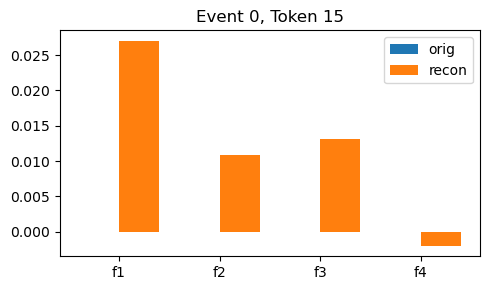

In [5]:
# Cell 5: Pick an event and a token index, then visualize
event_idx = 0     # change this to inspect a different event from the test set
token_idx = 15     # 0..T-1 (e.g., 0..17)

tokens_cont, tokens_id, gvec = test_ds[event_idx]
out = reconstruct_event(tokens_cont, tokens_id, gvec)

orig = out["orig"][token_idx]     # [4]
recon = out["x_hat"][token_idx]   # [4]

print(f"Event {event_idx}, Token {token_idx}")
print("Perplexity (event-level):", out["perplexity"])
print("Original (de-normalized):", orig.numpy())
print("Reconstruction (de-normalized):", recon.numpy())

# Simple bar comparison
feature_names = ["f1","f2","f3","f4"]  # replace with actual names if you have them
x = range(4)
plt.figure(figsize=(5,3))
plt.bar([i-0.2 for i in x], orig,  width=0.4, label="orig")
plt.bar([i+0.2 for i in x], recon, width=0.4, label="recon")
plt.xticks(x, feature_names)
plt.title(f"Event {event_idx}, Token {token_idx}")
plt.legend()
plt.tight_layout()
plt.show()

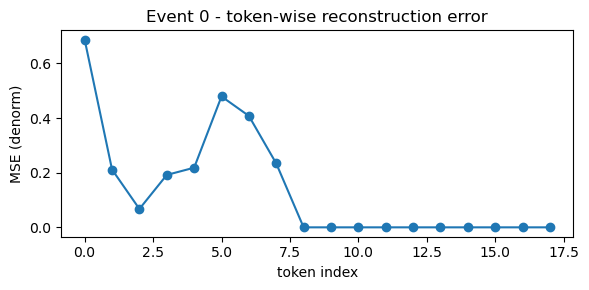

In [ ]:
import torch

# Cell 6 (optional): Inspect all tokens for an event at once
event_idx = 0
tokens_cont, tokens_id, gvec = test_ds[event_idx]
out = reconstruct_event(tokens_cont, tokens_id, gvec)

# L2 error per token (on de-normalized features)


per_token_mse = ((out["orig"] - out["x_hat"])**2).mean(dim=1)  # [T]
plt.figure(figsize=(6,3))
plt.plot(per_token_mse.numpy(), marker="o")
plt.xlabel("token index")
plt.ylabel("MSE (denorm)")
plt.title(f"Event {event_idx} - token-wise reconstruction error")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7 (optional, requires ipywidgets): interactive browsing
# pip install ipywidgets if needed; in JupyterLab enable the extension
try:
    import ipywidgets as widgets
    from IPython.display import clear_output, display

    T = int(cfg.data.n_tokens)
    def show(event_idx=0, token_idx=0):
        tokens_cont, tokens_id, gvec = test_ds[event_idx]
        out = reconstruct_event(tokens_cont, tokens_id, gvec)
        orig = out["orig"][token_idx]
        recon = out["x_hat"][token_idx]

        clear_output(wait=True)
        print(f"Event {event_idx}, Token {token_idx} | Perplexity: {out['perplexity']:.3f}")
        x = range(4)
        plt.figure(figsize=(5,3))
        plt.bar([i-0.2 for i in x], orig,  width=0.4, label="orig")
        plt.bar([i+0.2 for i in x], recon, width=0.4, label="recon")
        plt.xticks(x, ["f1","f2","f3","f4"])
        plt.legend()
        plt.tight_layout()
        plt.show()

    w_event = widgets.IntSlider(value=0, min=0, max=len(test_ds)-1, step=1, description="event")
    w_token = widgets.IntSlider(value=0, min=0, max=T-1, step=1, description="token")

    ui = widgets.VBox([w_event, w_token])
    out_area = widgets.interactive_output(show, {"event_idx": w_event, "token_idx": w_token})
    display(ui, out_area)
except Exception as e:
    print("ipywidgets not available:", e)

ipywidgets not available: name 'cfg' is not defined
